## Global Variables to decide what to load into Memory




In [ ]:
CREATE_DATABASE = False
REDUCE_MEM = True
LOAD_INS_VIEW = False
LOAD_INS_TYPE = True
LOAD_INS_COUNTRY = False
LOAD_INS_BALANCED = False

## Import Folder and Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# os.listdir("drive/MyDrive/CS342")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install geopy
# !{sys.executable} -m  pip install jupyter-resource-usage
import matplotlib.pyplot as plt
from geopy import Nominatim # Used for city to country conversions
import torch
from torch import nn
import csv
import time
import os
import json
import re
import pandas as pd
from geopy.geocoders import Nominatim
import numpy as np
import matplotlib.pyplot as plt
import math
from os.path import exists
from torch.utils.data import Dataset, DataLoader
import cv2 # for image processing
from PIL import Image # for image processing
from torchvision import transforms # for image processing
import copy
import random
import pickle
from torch.utils.data.sampler import SubsetRandomSampler

 # Make random deterministic for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Database Creation
Making a Pandas database from folders of data stored locally on my machine from a previous web scraping project

In [ ]:
error_dict = {"os_error_cnt" : 0}
DEBUG = False # for database creation only
def debug_print(statement):
    if DEBUG:
        print(statement)

In [ ]:
with open("drive/MyDrive/CS342/base_folder.dat", "rb") as f:
    base_folder = pickle.load(f)

In [ ]:
def get_violin_maker_folders(base_violin_code_folder):
    dir_list = os.listdir(base_violin_code_folder)
    return [x for x in dir_list if x.startswith("ViolinMaker-")]
if CREATE_DATABASE:
  violin_maker_folders = get_violin_maker_folders(base_folder)
  # violin_maker_folders[0:5]
  print("There are {} unique violin makers in this database".format(len(violin_maker_folders)))

In [ ]:
def get_instrument_paths(violin_maker_folders):
    instrument_folder_paths = []
    for violin_maker_folder in violin_maker_folders:
        violin_maker_path = base_folder+"/"+violin_maker_folder
        violin_list  = os.listdir(violin_maker_path)
        instruments = [(violin_maker_path + "/" + x) for x in violin_list if x.startswith("Instrument-")]
        if instruments:
            instrument_folder_paths.extend(instruments)
    return instrument_folder_paths
if CREATE_DATABASE:
  instrument_paths = get_instrument_paths(violin_maker_folders)
  print("There are {} unique instruments in this database".format(len(instrument_paths)))

In [ ]:
def parse_text(orig_dict):
    debug_print("Original Dict {}".format(orig_dict))
    desired_info = {
        "image_top" : None,
        "maker_name" : None,
        "country_made": None,
        "city_made" : None,
        "year_made": None,
        "instrument_type" : None,
        "year_sold": None,
        "sale_price_USD": None} # "image_back" : None,
    
    desired_info["maker_name"] = orig_dict['Maker Name']
    desired_info["city_made"] = orig_dict["Location"]
    desired_info["instrument_type"] = orig_dict["Instrument Type"]
    try:
        year_made = re.findall("\d+", orig_dict["Year Made"])
        if not year_made:
            debug_print("No year made in following: orig_dict[\"Year Made\"] {}".format(orig_dict["Year Made"]))
        else:
            assert(len(year_made)<2)
            desired_info["year_made"] = int(year_made[0])
    except Exception as e1:
        debug_print("year_made exception")
        debug_print(e1)
    try:
        year_sold = re.findall("\d+$", orig_dict['Date Sold'])
        if not year_sold:
            debug_print("No year_sold found in orig_dict[\"Sale Date\"] {}".format(orig_dict['Date Sold']))
        else:
            assert(len(year_sold)<2)
            desired_info["year_sold"] = int(year_sold[0])
    except Exception as e1:
        debug_print("year_sold exception")
        debug_print(e1)
    try:
        sales_price_USD = orig_dict['USD'].split("$")[1].replace(",", "")
        if not sales_price_USD:
            debug_print("No sales_price_USD found in {}".format( orig_dict['USD']))
        if "\n" in sales_price_USD:
            debug_print("\\\n in sales_price_USD")
            sales_price_USD = sales_price_USD.split("\n")[0]
        desired_info["sale_price_USD"] = int(sales_price_USD)
    except Exception as e1:
        debug_print("sales_price_USD exception")
        debug_print(e1)
    debug_print("Parsed Dict {}".format(desired_info))
    return desired_info

### Data Processing

Pad all images to fit the dimensions of desired_dimensions_after_downsample without stretching or squeezing the image. Instruments from different countries are associated with different dimensions, so any squeezing or stretching of an image that changes the ratio of height to width may result in a loss of accuracy in classifying instruments by country.

In [ ]:
def resize_image_with_padding(img_top_orig, desired_dimensions_after_downsample = (256, 256)):
    padding_val = img_top_orig[0][0].mean()
    y_len = img_top_orig.shape[0]
    x_len = img_top_orig.shape[1]
    y_conv_factor = y_len/desired_dimensions_after_downsample[0]
    x_conv_factor = x_len/desired_dimensions_after_downsample[1]
    used_conv_factor = max(x_conv_factor, y_conv_factor)
    x_len_after_conv = math.ceil(x_len/used_conv_factor)
    y_len_after_conv = math.ceil(y_len/used_conv_factor)
    num_x_padding =  (desired_dimensions_after_downsample[1] - x_len_after_conv)/2
    num_y_padding =  (desired_dimensions_after_downsample[0] - y_len_after_conv)/2
    
    if num_x_padding%1!=0:
        x_pad_tuple = ( int(math.floor(num_x_padding)), int(math.ceil(num_x_padding)))
    else:
        x_pad_tuple = (int(num_x_padding), int(num_x_padding))
    if num_y_padding%1!=0:
        y_pad_tuple = (int(math.floor(num_y_padding)), int(math.ceil(num_y_padding)))
    else:
        y_pad_tuple = (int(num_y_padding), int(num_y_padding))
    img_top_resized_no_padding = cv2.resize(img_top_orig, dsize=(x_len_after_conv, y_len_after_conv), interpolation=cv2.INTER_CUBIC)
    img_top_resized_padded = np.pad(img_top_resized_no_padding , [y_pad_tuple, x_pad_tuple, (0,0)], constant_values = (padding_val,padding_val))
    if img_top_resized_padded.shape != (desired_dimensions_after_downsample[0], desired_dimensions_after_downsample[1], 3):
        print("{}: {}".format("x_len_after_conv", x_len_after_conv))
        print("{}: {}".format("y_len_after_conv", y_len_after_conv))
        print("{}: {}".format("num_x_padding", num_x_padding))
        print("{}: {}".format("num_y_padding", num_y_padding))
        print("{}: {}".format("img_top_resized_no_padding.shape", img_top_resized_no_padding.shape))
        print("{}: {}".format("img_top_resized_padded.shape", img_top_resized_padded.shape))
        raise ValueError("img_top_resized_padded of incorrect shape of {}".format(img_top_resized_padded.shape))
    return img_top_resized_padded

In [ ]:
def get_image_data(instrument_path):
    instrument_files = os.listdir(instrument_path)
    top_image_candidates = [(instrument_path + "/" + x) for x in instrument_files if "top" in x and "back" not in x ]
    back_image_candidates = [(instrument_path + "/" + x) for x in instrument_files if "back" in x and "top" not in x]
    if len(top_image_candidates)>1:
        perfect_match_top =  [(instrument_path + "/" + x) for x in instrument_files if x=="top.jpg"]
        if len(perfect_match_top)>=1:
            top_image_candidates = perfect_match_top
    if len(back_image_candidates)>1:
        perfect_match_back =  [(instrument_path + "/" + x) for x in instrument_files if x=="back.jpg"]
        if len(perfect_match_back)>=1:
            back_image_candidates = perfect_match_back
    if len(top_image_candidates)==0 or len(back_image_candidates)==0: 
        return [], [] # Ignore all images from local directory if they do not contain at least one photo of back and front
    img_top_orig = cv2.imread(top_image_candidates[0])
    img_top_resized = resize_image_with_padding(img_top_orig)
    img_back_orig = cv2.imread(back_image_candidates[0])
    img_back_resized = resize_image_with_padding(img_back_orig)
    return img_top_resized, img_back_resized

In [ ]:
# Shows image with original ordering of dimensions
def show_image(image_arr):
    assert image_arr.shape[-1] == 3 
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    cax = ax.matshow(image_arr)
    fig.colorbar(cax)
    plt.show()

In [ ]:
# Shows image and saves image to google drive
def show_image_processed(img_tensor, save_name = "",title="", ticks = True):
    assert img_tensor.shape[0] == 3
    img_tensor_reshaped = torch.transpose(torch.transpose(img_tensor, 0 ,2),0,1)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    if ticks == False:
      ax.tick_params(left=False,bottom=False)
    cax = ax.matshow(img_tensor_reshaped)
    fig.colorbar(cax)
    if title!="":
      plt.title(title)
    if save_name!="":
      plt.savefig('drive/MyDrive/CS342/'+save_name + '.png',bbox_inches='tight')
    plt.show()

In [ ]:
def get_text_data_from_instrument_folder(instrument_path): 
    instrument_text_info_path = instrument_path + "/OrganizedViolinProfile.txt"
    try:
        with open(instrument_text_info_path) as f:
            instrument_text_info = f.read()
    except OSError as e:
        error_dict["os_error_cnt"] +=1
        return {}
    instrument_text_info_dict = json.loads(instrument_text_info)
    desired_info = parse_text(instrument_text_info_dict)
    return desired_info

In [ ]:
def get_all_instrument_data(instrument_paths):
    instrument_text_data_list = []
    for instrument_path in instrument_paths:
        debug_print("\nNew Data Attempt")
        instrument_data = get_text_data_from_instrument_folder(instrument_path)
        top_image_data, back_image_data = get_image_data(instrument_path)
        if len(top_image_data)>0 and len(back_image_data)>0:
            instrument_data["image_top"] = top_image_data 
            instrument_data["image_back"] = back_image_data 
        else:
            debug_print("{} does not contain compatible image data".format(instrument_path))
        if instrument_data:
            instrument_text_data_list.append(instrument_data)
        debug_print(instrument_data)
        debug_print("\n")
    return instrument_text_data_list

In [ ]:
# Creates the entire database to filter/select from in data selection phase 
if CREATE_DATABASE:
    all_instrument_data = get_all_instrument_data(instrument_paths)

## Feature Extraction

Predict the country for each instrument based off the historical city where the instrument was made

In [ ]:
def extrapolate_country_made_():
    city_to_country_dict = {}
    city_to_country_dict_path = "inside local UT Neural Network homework folder"
    if exists(city_to_country_dict_path):
        with open(city_to_country_dict_path, mode='r') as inp:
            reader = csv.reader(inp)
            city_to_country_dict = {rows[0]:rows[1] for rows in reader}
    geolocator = Nominatim(user_agent = "city_to_country")
    def convert_city_to_country(city_name):
      try:
          if city_name in city_to_country_dict.keys():
              country = city_to_country_dict[city_name]
          else:
              time.sleep(.05)
              location = geolocator.geocode(city_name, exactly_one=True)
              print(location)
              country = location[-2].split(", ")[-1] 
              city_to_country_dict[city_name] = country
      except Exception as e:
          city_to_country_dict[city_name] = None
          print("Unable to convert {} due to {}".format(city_name, e))
          return None
      return country

    for instrument_data in all_instrument_data:
        instrument_data['country_made'] = convert_city_to_country(instrument_data["city_made"])

In [ ]:
if CREATE_DATABASE:
    extrapolate_country_made_()

In [ ]:
if CREATE_DATABASE:
    # Update Dictionary File
    w = csv.writer(open("city_to_country_dict.csv", "w"))
    # loop over dictionary keys and values
    for key, val in city_to_country_dict.items():
        # write every key and value to file
        w.writerow([key, val])

In [ ]:
# if "alexnet_ins_extra_layer" not in locals():
with open("drive/MyDrive/CS342/alexnet_ins.dat", "rb") as f:
  alexnet_ins= pickle.load(f)
with open("drive/MyDrive/CS342/alexnet_ins__cpu.dat", "wb") as f:
  pickle.dump(alexnet_ins.to(torch.device("cpu")), f)

In [ ]:
if CREATE_DATABASE:
  df = pd.DataFrame(all_instrument_data) 
  with open("drive/MyDrive/CS342/df.dat", "wb") as f:
      pickle.dump(df, f)
else:
  with open("drive/MyDrive/CS342/df.dat", "rb") as f:
    df = pickle.load(f)
df.head()

,image_top,maker_name,country_made,city_made,year_made,instrument_type,year_sold,sale_price_USD,image_back
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Robert Clemens,United States,Chicago,NaN,Violin,2005.0,3738.0,"[[[183, 183, 183], [183, 183, 183], [183, 183,..."
1,"[[[254, 254, 254], [254, 254, 254], [254, 254,...",John Frederick Lott II,United Kingdom,London,1840.0,Violin,NaN,NaN,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,"[[[239, 239, 239], [239, 239, 239], [239, 239,...",John Frederick Lott II,United Kingdom,London,1840.0,Violin,NaN,NaN,"[[[233, 233, 233], [233, 233, 233], [233, 233,..."
3,"[[[244, 244, 244], [244, 244, 244], [244, 244,...",John Frederick Lott II,United Kingdom,London,1850.0,Violin,NaN,NaN,"[[[248, 248, 248], [248, 248, 248], [248, 248,..."
4,None,John Frederick Lott II,United Kingdom,London,1850.0,Violin,NaN,NaN,NaN


## Data Selection

1. Select the rows with the seven most popular countries that historically account for over 95% of all fine violin making.
2. Select instruments 'Violin','Cello','Viola','Bass' which account for over 95% of all stringed instruments from the data. 'Bass' is later removed due to insufficient data.
3. Select instruments that we have image data for (either front and back or just front depending on classification problem).
4. Make three seperate databases for each classification problem to make it easier to convert the desired x,y labels into dataset/dataloader objects.

In [ ]:
popular_countries = ['Italia', 'France', 'United Kingdom','United States','Deutschland','Österreich','Nederland']
desired_instrument_types = ['Violin','Cello','Viola','Bass']

Create database of instruments with a valid front image, labeled image type, and of the seven most popular countries

In [ ]:
if LOAD_INS_COUNTRY or CREATE_DATABASE:
    valid_image_country_instrument_df = df[ (df['country_made'].isin(popular_countries)) & (df['instrument_type'].isin(desired_instrument_types))& (~ df['image_top'].isnull()) ]
    valid_image_country_instrument_df.head()

Create a database of all instruments with valid front and back photos

In [ ]:
if LOAD_INS_VIEW or CREATE_DATABASE:
    valid_image_back_front_df = df.loc[:, ['image_back', 'image_top']][(~ df['image_top'].isnull())].dropna(subset=['image_back'])
    valid_image_back_front_df.head()

Create a database of instruments with a valid front image that is from one the seven most popular countries


In [ ]:
if LOAD_INS_COUNTRY or CREATE_DATABASE:
    valid_image_country_df = df[ (df['country_made'].isin(popular_countries)) &(~ df['image_top'].isnull()) ]

Create a database of instruments with a valid front image that has a valid front image

In [ ]:
if LOAD_INS_TYPE or LOAD_INS_BALANCED or CREATE_DATABASE:
    valid_image_instrument_df = df[ (df['instrument_type'].isin(desired_instrument_types)) &(~ df['image_top'].isnull()) ]

In [ ]:
if REDUCE_MEM:
    del df

## Data Categorization
Convert instrument type and country made location to categorical variables as an extra column each.

In [ ]:
if LOAD_INS_COUNTRY or LOAD_INS_TYPE or LOAD_INS_BALANCED:
  country_to_idx = {ch:i for i,ch in enumerate(popular_countries)}
  idx_to_country = {i:ch for i,ch in enumerate(popular_countries)}
  print(idx_to_country)
  instrument_type_to_idx = {ch:i for i,ch in enumerate(desired_instrument_types)}
  idx_to_instrument_type = {i:ch for i,ch in enumerate(desired_instrument_types)}
  print(idx_to_instrument_type)

{0: 'Italia', 1: 'France', 2: 'United Kingdom', 3: 'United States', 4: 'Deutschland', 5: 'Österreich', 6: 'Nederland'}
{0: 'Violin', 1: 'Cello', 2: 'Viola', 3: 'Bass'}


In [ ]:
# Creates Categorization Column for instrument type for valid_image_instrument_df
if CREATE_DATABASE or LOAD_INS_TYPE:
  fn_instrument = lambda row: instrument_type_to_idx[row.instrument_type] # define a function for the new column
  col_instrument = valid_image_instrument_df.apply(fn_instrument, axis=1) # get column data with an index
  valid_image_instrument_df = valid_image_instrument_df.assign(categorical_instrument=col_instrument.values) # assign values to column 'c'
  print("valid_instrument_df.shape: {}".format(valid_image_instrument_df.shape))

In [ ]:
# Creates Categorization Column for country made
if CREATE_DATABASE or LOAD_INS_COUNTRY:
  fn_country = lambda row: country_to_idx[row.country_made] # define a function for the new column
  col_country = valid_image_country_df.apply(fn_country, axis=1) # get column data with an index
  valid_image_country_df = valid_image_country_df.assign(categorical_country=col_country.values) # assign values to column 'c'
  print("Instruments in valid_image_country_df: {}".format(valid_image_country_df.shape[0]))

Instruments in valid_image_country_df: 7904


In [ ]:
'''
  For future optimization: For benchmark testing, get multiple samples so that each test_loader is unique to improve reliability of accuracy scoring. 
'''
def get_samples(df, balance_type = None, num_samples = 1):
  df=df.reset_index(drop=True)
  n_total = df.shape[0]
  samples_list = []
  for sample_num in range(num_samples):
    # Future Optimizations: This code could be modified to increase generalizability 
    if balance_type=="instrument_type":
      index_violins = df.index[df['categorical_instrument'] == 0].tolist()
      index_violas = df.index[df['categorical_instrument'] == 1].tolist()
      index_cellos = df.index[df['categorical_instrument'] == 2].tolist()
      index_violins_test = random.sample(index_violins,34)
      index_violas_test = random.sample(index_violas,33)
      index_cellos_test = random.sample(index_cellos,33)
      test_indices = index_violins_test + index_violas_test + index_cellos_test
    elif balance_type=="country_made":
      index_italy = df.index[df['categorical_country'] == 0].tolist()
      index_france = df.index[df['categorical_country'] == 1].tolist()
      index_uk = df.index[df['categorical_country'] == 2].tolist()
      index_usa = df.index[df['categorical_country'] == 3].tolist()
      index_germany = df.index[df['categorical_country'] == 4].tolist()
      index_austria = df.index[df['categorical_country'] == 5].tolist()
      index_holland = df.index[df['categorical_country'] == 6].tolist()

      index_italy_test = random.sample(index_italy,15)
      index_france_test = random.sample(index_france,15)
      index_uk_test = random.sample(index_uk,14)
      index_usa_test = random.sample(index_usa,14)
      index_germany_test = random.sample(index_germany,14)
      index_austria_test = random.sample(index_austria,14)
      index_holland_test = random.sample(index_holland,14)
      test_indices = index_italy_test + index_france_test + index_uk_test + index_usa_test + index_germany_test + index_austria_test + index_holland_test
    else:
      test_indices = random.sample(range(n_total), int(.1*n_total))
    not_test_indices = list(set(range(n_total)) - set(test_indices))
    num_train = int(len(not_test_indices)*.8)
    train_indices = random.sample(not_test_indices, num_train)
    val_indices = list(set(range(n_total)) - set(train_indices) - set(test_indices))

    # Ensure that all index values are unique. Not efficient code, but doesn't matter due to only O(N^2) time
    for i in val_indices:
      assert i not in train_indices
      assert i not in test_indices
    for i in train_indices:
      assert i not in val_indices
      assert i not in test_indices
    for i in test_indices:
      assert i not in val_indices
      assert i not in train_indices
    # Sanity length check
    assert len(test_indices) + len(train_indices) + len(val_indices) == n_total
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    samples_list.append( (train_sampler, test_sampler, val_sampler))
  return samples_list


In [ ]:
if LOAD_INS_BALANCED or CREATE_DATABASE:
    violins_sampled = valid_image_instrument_df[valid_image_instrument_df["categorical_instrument"]==0].sample(n=654)
    violas_sampled = valid_image_instrument_df[valid_image_instrument_df["categorical_instrument"]==1].sample(n=654)
    cellos_sampled = valid_image_instrument_df[valid_image_instrument_df["categorical_instrument"]==2].sample(n=654)
    frames = [violins_sampled, violas_sampled, cellos_sampled]
    balanced_instrument_df = pd.concat(frames)
    balanced_instrument_df["instrument_type"].value_counts()
    balanced_image_instrument_type_only = balanced_instrument_df[["image_top","categorical_instrument"]]
    del balanced_instrument_df
    samples_balanced = get_samples(balanced_image_instrument_type_only, balance_type="instrument_type", num_samples=1)
    balanced_image_instrument_type_only = balanced_image_instrument_type_only.to_numpy()

In [ ]:
if LOAD_INS_COUNTRY or CREATE_DATABASE:
    valid_image_country_df = valid_image_country_df.reindex(columns=['image_top', 'maker_name', 'country_made', 'city_made', 'year_made',
           'instrument_type', 'year_sold', 'sale_price_USD',
           'categorical_country'])

In [ ]:
if LOAD_INS_TYPE or CREATE_DATABASE:
  image_instrument_type_only = valid_image_instrument_df[["image_top","categorical_instrument"]]

In [ ]:
if LOAD_INS_COUNTRY or CREATE_DATABASE:
  image_country_only = valid_image_country_df[["image_top","categorical_country"]]

In [ ]:
valid_image_country_PIK = "drive/MyDrive/CS342/valid_image_country_df.dat"
valid_image_instrument_PIK = "drive/MyDrive/CS342/valid_image_instrument_df.dat"
valid_image_country_instrument_PIK = "drive/MyDrive/CS342/valid_image_country_instrument_df.dat"
valid_image_back_front_PIK = "drive/MyDrive/CS342/valid_image_back_front.dat"
image_instrument_type_only_PIK = "drive/MyDrive/CS342/image_instrument_type_only.dat"
image_country_only_PIK = "drive/MyDrive/CS342/image_country_only.dat"

Dump or load necessary dataframes

In [ ]:
if CREATE_DATABASE:
    with open(valid_image_country_PIK, "wb") as f:
        pickle.dump(valid_image_country_df, f)
    with open(valid_image_instrument_PIK, "wb") as f:
        pickle.dump(valid_image_instrument_df, f)
    with open(valid_image_country_PIK, "wb") as f:
        pickle.dump(valid_image_country_instrument_df, f)
    with open(valid_image_back_front_PIK, "wb") as f:
        # numpy array of image data with front and back images labeled 0 and 1
        pickle.dump(valid_image_back_front, f)
    with open(image_instrument_type_only_PIK, "wb") as f:
        pickle.dump(image_instrument_type_only, f)
    with open(image_country_only_PIK, "wb") as f:
        pickle.dump(image_country_only, f)

## A Few Data Stat Visualization

In [ ]:
try:
  print("Instruments in df: {}".format(df.shape[0]))
except Exception:
  pass
try:
  print("Instruments in valid_image_country_df: {}".format(valid_image_country_df.shape[0]))
except Exception:
  pass
try:
  print("Instruments in valid_image_country_instrument_df: {}".format(valid_image_country_instrument_df.shape[0]))
except Exception:
  pass
try:
  print("Instruments in valid_image_back_front: {}".format(valid_image_back_front.shape[0]))
except Exception:
  pass

Instruments in valid_image_country_df: 7904
Instruments in valid_image_country_instrument_df: 7848


In [ ]:
if REDUCE_MEM:
  try:
      del valid_image_country_instrument_df
  except:
      pass

In [ ]:
if LOAD_INS_TYPE:
  percent_violin = int(100*max(valid_image_instrument_df['instrument_type'].value_counts())/sum(valid_image_instrument_df['instrument_type'].value_counts()))
  print(valid_image_instrument_df['instrument_type'].value_counts())
  print("Violins account for {} percent of all instruments".format(percent_violin))

Violin    6959
Viola      795
Cello      654
Bass        10
Name: instrument_type, dtype: int64
Violins account for 82 percent of all instruments


In [ ]:
if LOAD_INS_COUNTRY:
  valid_image_country_df["country_made"].value_counts()
  percent_italian_instruments =  max(valid_image_country_df["country_made"].value_counts())/sum(valid_image_country_df["country_made"].value_counts())
  print("Italian instruments account for {:.1%} percent of all instruments".format(percent_italian_instruments))

Italian instruments account for 62.3% percent of all instruments


###Computational Experiment: Balanced Dataset versus Weighted Loss
Question: How should I handle imbalanced class data?
The Instrument Dataset I have collected is extremely unbalanced. 86% of all instruments are violins, with the remaining 14% consisting mainly of violas and cellos. With a normal loss function and unbalanced dataset, our model will struggle to learn and identify rare classes. The model will almost always predict Violin, and learning may plateau. I am testing two different techniques used to handle an unbalanced dataset.<br>
Option 1: 
Balance the Dataset by sampling an equal number of Violin, Violas and Cellos.<br>
Option 2: 
Have a different weight for each class (with larger weights for rare classes) and then normalize by the sum of the weights.


In [ ]:
# Option 2 of different weights for each label
if LOAD_INS_TYPE or LOAD_INS_BALANCED:
  class_weights_ins = torch.Tensor([1/i for i in valid_image_instrument_df.categorical_instrument.value_counts() / len(valid_image_instrument_df)]).to(device)
  class_weights_ins

In [ ]:
# Option 2 of different weights for each label
if LOAD_INS_COUNTRY:
  class_weights_country_made = torch.Tensor([1/i for i in valid_image_country_df.categorical_country.value_counts() / len(valid_image_country_df)]).to(device)
  print(class_weights_country_made)

tensor([  1.6062,   6.2236,  11.7794,  17.2576,  20.0101,  68.1379, 108.2740],
       device='cuda:0')


In [ ]:
if LOAD_INS_TYPE:
  ins_type_samples = get_samples(image_instrument_type_only, balance_type="instrument_type",num_samples = 1) 
  image_ins_type_only = image_instrument_type_only.to_numpy()  

In [ ]:
if LOAD_INS_COUNTRY:
  ins_country_samples = get_samples(image_country_only, balance_type="country_made", num_samples = 1)  
  image_country_only = image_country_only.to_numpy() 

In [ ]:
if LOAD_INS_VIEW:
  # no need balance because database is already 50% front and back instruments
  ins_view_samples = get_samples(valid_image_back_front_df, balance_type=None, num_samples=1)
  valid_image_back_front = valid_image_back_front_df.to_numpy()  
  del valid_image_back_front_df
  type(valid_image_back_front)

## Image Processing:
Normalize pixel values to help each model learn.
    

### Computation Experiment: Image Normalization

What types of Image Normalization and Standardization lead to the best performance?

Option 1: Gloabal Standardization
Calculate the standard deviation and mean across all images per RGB channel, then use these values to standardize the pixel values for each image.

Option 2: Local Standardization
Calculate the standard deviation and mean of one particular image per RGB channel, then use these statistics to standardize the pixels of the same particular image for each channel.


In [ ]:
'''Global versus Local Standardization
Imagine that each image is a (2, 3) array, where the dimension represents each color, and that there are three total images

Image 1:  [1, 1, 1]
          [1, 1, 1]

Image 2:  [.5, .5, .5]
          [.5, .5, .5]

Image
# [1,1,1,1] 
# [.5,.5,.5]

# Local Standardization: Normalize with mean RGB values  of (.5,.5,.5)
Image 1:  [.5,.5,.5]
          [.5,.5,.5]
Image 2:  [.5,.5,.5]
          [.5,.5,.5]

# Global Standardization: (Subtract the global mean of each color channel)
Image 1:  [.25,.25,.25]
          [.25,.25,.25]

Image 2:  [-.25,-.25,-.25]
          [-.25,-.25,-.25]
'''


'Global versus Local Standardization\nImagine that each image is a (2, 3) array, where the dimension represents each color, and that there are three total images\n\nImage 1:  [1, 1, 1]\n          [1, 1, 1]\n\nImage 2:  [.5, .5, .5]\n          [.5, .5, .5]\n\nImage\n# [1,1,1,1] \n# [.5,.5,.5]\n\n# Local Standardization: Normalize with mean RGB values  of (.5,.5,.5)\nImage 1:  [.5,.5,.5]\n          [.5,.5,.5]\nImage 2:  [.5,.5,.5]\n          [.5,.5,.5]\n\n# Global Standardization: (Subtract the global mean of each color channel)\nImage 1:  [.25,.25,.25]\n          [.25,.25,.25]\n\nImage 2:  [-.25,-.25,-.25]\n          [-.25,-.25,-.25]\n'

In [ ]:
# Inspired From https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/

# Local Standardization
transform_1 = transforms.Compose([
#     transforms.ToPILImage(),
    #[1]
 transforms.Resize([256, 256]),                  #[2]
#  transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
         )])
# transform_2 = transforms.Compose([
#         #     transforms.ToPILImage(),
#             #[1]
#          transforms.Resize([224, 224]),                 
#         #  transforms.CenterCrop(224),               
#          transforms.ToTensor(),
#         transforms.FiveCrop(size=(100, 100)),
# #          transforms.Normalize(                      
# #          mean=[0.485, 0.456, 0.406],               
# #          std=[0.2, 0.224, 0.225])               
#          ])

# Wait on performing global standardization inside preprocess_images function
transform_3 = transforms.Compose([
        #     transforms.ToPILImage(),
            #[1]
         transforms.Resize([224, 224]),                 
#          transforms.CenterCrop(224),               
         transforms.ToTensor(),             
         ])

In [ ]:
def convert_np_to_tensor(img_orig_np):
    img = Image.fromarray(img_orig_np.astype('uint8'), 'RGB')
    return img
    
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def preprocess_images(image_arr, transform_funct, mode="positive_global_standardization", image_in_index_1 = False):
    if mode=="positive_global_standardization":     
        mean_pixel_color_values = image_arr[0][0].reshape(-1, image_arr[0][0].shape[-1]).mean(axis=0)
        print("mean_pixel_color_values: {}" .format(mean_pixel_color_values))
        for index, i in enumerate(image_arr):
            i[0] = i[0].astype(np.float32) 
        for color_index, mean_val in enumerate(mean_pixel_color_values):
            image_arr[0][0][:,:,color_index]-=mean_val
            image_arr[0][0][:,:,color_index] /=255
            image_arr[0][0][:,:,color_index] = normalize_data(image_arr[0][0][:,:,color_index])
    elif mode=="local_standardization":
        raise NotImplemented() # transformation currently occurs outside of function
    for i in range(len(image_arr)):
        image_arr[i][0] = convert_np_to_tensor(image_arr[i][0])
        image_arr[i][0] = transform_funct(image_arr[i][0]) 
        if image_in_index_1:
            image_arr[i][1] = convert_np_to_tensor(image_arr[i][1])
            image_arr[i][1] = transform_funct(image_arr[i][1])
    return image_arr

In [ ]:
def convert_np_to_tensor(img_orig_np):
    img = Image.fromarray(img_orig_np.astype('uint8'), 'RGB')
    return img
    
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def preprocess_images(image_arr, transform_funct, mode="positive_global_standardization", image_in_index_1 = False):
    if mode=="positive_global_standardization":     
        mean_pixel_color_values = image_arr[0][0].reshape(-1, image_arr[0][0].shape[-1]).mean(axis=0)
        print("mean_pixel_color_values: {}" .format(mean_pixel_color_values))
        for i in image_arr:
            i[0] = i[0].astype(np.float32)
        for color_index, mean_val in enumerate(mean_pixel_color_values):
            image_arr[0][0][:,:,color_index]-=mean_val
            image_arr[0][0][:,:,color_index] /=255
            image_arr[0][0][:,:,color_index] = normalize_data(image_arr[0][0][:,:,color_index])
    elif mode=="local_standardization":
        raise NotImplemented()
    for i in range(len(image_arr)):
        image_arr[i][0] = convert_np_to_tensor(image_arr[i][0])
        image_arr[i][0] = transform_funct(image_arr[i][0]) 
        if image_in_index_1:
            image_arr[i][1] = convert_np_to_tensor(image_arr[i][1])
            image_arr[i][1] = transform_funct(image_arr[i][1])
    return image_arr

In [ ]:
if LOAD_INS_BALANCED or CREATE_DATABASE:
    balanced_image_ins_type_only = preprocess_images(balanced_image_instrument_type_only, transform_3, mode="positive_global_standardization")

In [ ]:
if LOAD_INS_COUNTRY or CREATE_DATABASE:
  image_country_only = preprocess_images(image_country_only, transform_3, mode="positive_global_standardization") 

mean_pixel_color_values: [177.3052063  186.73027039 204.57907104]


In [ ]:
if LOAD_INS_TYPE or CREATE_DATABASE:
  image_ins_type_only = preprocess_images(image_ins_type_only, transform_3, mode="positive_global_standardization")

In [ ]:
if LOAD_INS_VIEW or CREATE_DATABASE:
  valid_image_back_front = preprocess_images(valid_image_back_front, transform_3, mode="positive_global_standardization", image_in_index_1 = True)

In [ ]:
if CREATE_DATABASE:
    with open("drive/MyDrive/CS342/class_weights_country_made.dat", "wb") as f:
        pickle.dump(class_weights_country_made, f)
if LOAD_INS_COUNTRY:
    if "class_weights_country_made" not in locals():
      with open("drive/MyDrive/CS342/class_weights_country_made.dat", "rb") as f:
          class_weights_country_made = pickle.load(f)

In [ ]:
if CREATE_DATABASE:
    with open("drive/MyDrive/CS342/image_ins_type_only.dat", "wb") as f:
        pickle.dump(image_ins_type_only, f)
if LOAD_INS_TYPE:
    if "image_ins_type_only" not in locals():
      with open("drive/MyDrive/CS342/image_ins_type_only.dat", "rb") as f:
        image_ins_type_only = pickle.load(f)

In [ ]:
if CREATE_DATABASE:
    with open("drive/MyDrive/CS342/image_country_only.dat", "wb") as f:
        pickle.dump(image_country_only, f)
if LOAD_INS_COUNTRY:
    if "image_country_only" not in locals():
      with open("drive/MyDrive/CS342/image_country_only.dat", "rb") as f:
        image_country_only = pickle.load(f)

In [ ]:
if CREATE_DATABASE:
    with open("drive/MyDrive/CS342/valid_image_back_front.dat", "wb") as f:
        pickle.dump(valid_image_back_front, f)
if LOAD_INS_VIEW:
    if "valid_image_back_front" not in locals():
      with open("drive/MyDrive/CS342/valid_image_back_front.dat", "rb") as f:
          valid_image_back_front = pickle.load(f)

In [ ]:
'''
Coverts an array of rows wherethere are two columns (one image of front and one image of back) 
into an array with twice as many rows where the first column is either a photo of the front or back 
and the second column is the label.
'''
def create_image_to_back_or_front_category_np(image_arr_all):
    image_category_list = []
    for index, image_arr in enumerate(image_arr_all):
        image_category_pair_1 = np.array([image_arr[0], 0], dtype=object)
        image_category_list.append(image_category_pair_1)
        image_category_pair_2 = np.array([image_arr[1], 1], dtype=object)
        image_category_list.append(image_category_pair_2)

    image_category_np = np.array(image_category_list)
    del image_category_list
    print("image_category_np.shape: {}".format(image_category_np.shape))
    return image_category_np

In [ ]:
if LOAD_INS_VIEW:
  image_to_back_or_front_category_np = create_image_to_back_or_front_category_np(valid_image_back_front)
  print("image_to_back_or_front_category_np[7000][0].shape: {} ".format(image_to_back_or_front_category_np[7000][0].shape))

## Data Loading:
  Since the image files take up a lot of RAM, below is code to import only the files that you need

In [ ]:
if CREATE_DATABASE:
    with open("drive/MyDrive/CS342/class_weights_ins.dat", "wb") as f:
        pickle.dump(class_weights_ins, f)
if LOAD_INS_VIEW or LOAD_INS_TYPE:
    if "class_weights_ins" not in locals():
      with open("drive/MyDrive/CS342/class_weights_ins.dat", "rb") as f:
          class_weights_ins = pickle.load(f)

In [ ]:
# Note: On Google Colab, this database takes over half of allocated RAM
if CREATE_DATABASE:
  with open("drive/MyDrive/CS342/image_to_back_or_front_category_np.dat", "wb") as f:
      pickle.dump(image_to_back_or_front_category_np, f)
if LOAD_INS_VIEW:
  if "image_to_back_or_front_category_np" not in locals():
    with open("drive/MyDrive/CS342/image_to_back_or_front_category_np.dat", "rb") as f:
        image_to_back_or_front_category_np = pickle.load(f)

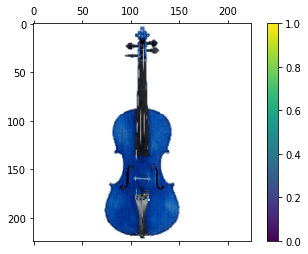

In [ ]:
if LOAD_INS_VIEW:
  show_image_processed(image_to_back_or_front_category_np[7000][0])
if LOAD_INS_COUNTRY:
  show_image_processed(image_country_only[7000][0])
if LOAD_INS_TYPE:
  show_image_processed(image_ins_type_only[7000][0])

## Create PyTorch Dataset & DataLoaders

In [ ]:
class InstrumentDataset(Dataset):
    def __init__(self, data_as_np):
        # data loading
        self.x = data_as_np[:, 0]
        self.y = data_as_np[:, 1]
        self.n_samples = data_as_np.shape[0]
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

### Get instrument and country Dataset and DataLoader

In [ ]:
def get_data_loaders(numpy_arr, train_sampler, test_sampler, val_sampler, batch_size):
    dataset = InstrumentDataset(numpy_arr)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,  sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,  sampler=val_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    return train_loader, val_loader, test_loader

def convert_np_array_to_dataloaders(numpy_arr, samples, batch_size=8):
    train_sampler, test_sampler, val_sampler = samples
    train_loader, val_loader, test_loader = get_data_loaders(numpy_arr, train_sampler, test_sampler, val_sampler, batch_size)
    return train_loader, val_loader, test_loader
                               

Future optimizations: create multiple dataloader objects for each categorization problem

In [ ]:
if LOAD_INS_TYPE:
  train_loader_ins, val_loader_ins, test_loader_ins = convert_np_array_to_dataloaders(image_ins_type_only,ins_type_samples[0])

In [ ]:
if LOAD_INS_COUNTRY:
  train_loader_country, val_loader_country, test_loader_country= convert_np_array_to_dataloaders(image_country_only, ins_country_samples[0])

In [ ]:
if LOAD_INS_VIEW:
  ins_view_loaders = convert_np_array_to_dataloaders(image_to_back_or_front_category_np, ins_view_samples[0]) # View corresponds to front of instrument or back of instrument
  train_loader_ins_view, val_loader_ins_view, test_loader_ins_view = ins_view_loaders

In [ ]:
if LOAD_INS_BALANCED:
  train_loader_ins_balanced, val_loader_ins_balanced, test_loader_ins_balanced = convert_np_array_to_dataloaders(balanced_image_ins_type_only, samples_balanced[0])

In [ ]:
if CREATE_DATABASE:
  with open("drive/MyDrive/CS342/train_loader_country.dat", "wb") as f:
    pickle.dump(train_loader_country, f)
  with open("drive/MyDrive/CS342/val_loader_country.dat", "wb") as f:
    pickle.dump(val_loader_country, f)
  with open("drive/MyDrive/CS342/test_loader_country.dat", "wb") as f:
    pickle.dump(test_loader_country, f)

  with open("drive/MyDrive/CS342/train_loader_ins_view.dat", "wb") as f:
    pickle.dump(train_loader_ins_view, f)
  with open("drive/MyDrive/CS342/val_loader_ins_view.dat", "wb") as f:
    pickle.dump(val_loader_ins_view, f)
  with open("drive/MyDrive/CS342/test_loader_ins_view.dat", "wb") as f:
    pickle.dump(test_loader_ins_view, f)

  with open("drive/MyDrive/CS342/train_loader_ins.dat", "wb") as f:
    pickle.dump(train_loader_ins, f)
  with open("drive/MyDrive/CS342/val_loader_ins.dat", "wb") as f:
    pickle.dump(val_loader_ins, f)
  with open("drive/MyDrive/CS342/test_loader_ins.dat", "wb") as f:
    pickle.dump(test_loader_ins, f)

  with open("drive/MyDrive/CS342/train_loader_ins_balanced.dat", "wb") as f:
    pickle.dump(train_loader_ins_balanced, f)
  with open("drive/MyDrive/CS342/val_loader_ins_balanced.dat", "wb") as f:
    pickle.dump(val_loader_ins_balanced, f)
  with open("drive/MyDrive/CS342/test_loader_ins_balanced.dat", "wb") as f:
    pickle.dump(test_loader_ins_balanced, f)

## Create Models

In [ ]:
def set_parameter_requires_grad(model, modify_pretrained_layers):
    if not modify_pretrained_layers:
        for param in model.parameters():
            param.requires_grad = False

#loads and modifies alexNet       
def setup_alexnet(num_classes, modify_pretrained_layers = True):
    alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True) # always use pretrained due to limited dataset
    set_parameter_requires_grad(alexnet, modify_pretrained_layers)
    alexnet.classifier[6] = nn.Linear(4096,num_classes)
    return alexnet.to(device)


In [ ]:
def show_parameters_and_grad(model):
  for i in list(model.parameters()):
    print(i.shape)
    print(i.requires_grad)

In [ ]:
# torch.cuda.empty_cache() # helpful function to rid memory off GPU

In [ ]:
if LOAD_INS_TYPE:
  alexnet_ins = setup_alexnet(len(desired_instrument_types), modify_pretrained_layers = True)
  criterion_ins = nn.CrossEntropyLoss(weight=class_weights_ins,reduction='mean')
  # optimizer_ins = torch.optim.Adam(alexnet_ins.parameters(), lr=1e-3)
  optimizer_ins = torch.optim.SGD(alexnet_ins.parameters(), lr=0.0002, momentum=0.9, weight_decay=1e-4)
  num_epochs_ins = 10
  show_parameters_and_grad(alexnet_ins)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


torch.Size([64, 3, 11, 11])
True
torch.Size([64])
True
torch.Size([192, 64, 5, 5])
True
torch.Size([192])
True
torch.Size([384, 192, 3, 3])
True
torch.Size([384])
True
torch.Size([256, 384, 3, 3])
True
torch.Size([256])
True
torch.Size([256, 256, 3, 3])
True
torch.Size([256])
True
torch.Size([4096, 9216])
True
torch.Size([4096])
True
torch.Size([4096, 4096])
True
torch.Size([4096])
True
torch.Size([4, 4096])
True
torch.Size([4])
True


In [ ]:
if LOAD_INS_TYPE:
  alexnet_ins_off_shelf = setup_alexnet(len(desired_instrument_types), modify_pretrained_layers = False)
  criterion_ins_off_shelf = nn.CrossEntropyLoss(weight=class_weights_ins,reduction='mean')
  # optimizer_ins = torch.optim.Adam(alexnet_ins.parameters(), lr=1e-3)
  optimizer_ins_off_shelf = torch.optim.SGD(alexnet_ins_off_shelf.parameters(), lr=0.0002, momentum=0.9)
  num_epochs_ins_off_shelf = 10
  show_parameters_and_grad(alexnet_ins_off_shelf)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


torch.Size([64, 3, 11, 11])
False
torch.Size([64])
False
torch.Size([192, 64, 5, 5])
False
torch.Size([192])
False
torch.Size([384, 192, 3, 3])
False
torch.Size([384])
False
torch.Size([256, 384, 3, 3])
False
torch.Size([256])
False
torch.Size([256, 256, 3, 3])
False
torch.Size([256])
False
torch.Size([4096, 9216])
False
torch.Size([4096])
False
torch.Size([4096, 4096])
False
torch.Size([4096])
False
torch.Size([4, 4096])
True
torch.Size([4])
True


In [ ]:
if LOAD_INS_COUNTRY:
  alexnet_country = setup_alexnet(len(popular_countries), modify_pretrained_layers = True)
  criterion_country = nn.CrossEntropyLoss(weight=class_weights_country_made, reduction='mean')
  # optimizer_country = torch.optim.Adam(alexnet_country.parameters(), lr=1e-3)
  optimizer_country = torch.optim.SGD(alexnet_country.parameters(), lr=0.001)
  num_epochs_country = 10
  show_parameters_and_grad(alexnet_country)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


torch.Size([64, 3, 11, 11])
True
torch.Size([64])
True
torch.Size([192, 64, 5, 5])
True
torch.Size([192])
True
torch.Size([384, 192, 3, 3])
True
torch.Size([384])
True
torch.Size([256, 384, 3, 3])
True
torch.Size([256])
True
torch.Size([256, 256, 3, 3])
True
torch.Size([256])
True
torch.Size([4096, 9216])
True
torch.Size([4096])
True
torch.Size([4096, 4096])
True
torch.Size([4096])
True
torch.Size([7, 4096])
True
torch.Size([7])
True


In [ ]:
if LOAD_INS_COUNTRY:
  alexnet_country_off_shelf = setup_alexnet(len(popular_countries), modify_pretrained_layers = False)
  criterion_country_off_shelf = nn.CrossEntropyLoss(weight=class_weights_country_made, reduction='mean')
  # optimizer_country = torch.optim.Adam(alexnet_country.parameters(), lr=1e-3)
  optimizer_country_off_shelf = torch.optim.SGD(alexnet_country.parameters(), lr=0.001)
  num_epochs_country_off_shelf = 10
  show_parameters_and_grad(alexnet_country)

In [ ]:
if LOAD_INS_COUNTRY:
  alexnet_country_OPT2 = setup_alexnet(len(popular_countries), modify_pretrained_layers = True)
  criterion_country_OPT2 = nn.CrossEntropyLoss(weight=class_weights_country_made, reduction='mean')
  # optimizer_country = torch.optim.Adam(alexnet_country.parameters(), lr=1e-3)
  optimizer_country_OPT2 = torch.optim.SGD(alexnet_country.parameters(), lr=0.001)
  num_epochs_country_OPT2 = 10
  show_parameters_and_grad(alexnet_country_OPT2)

In [ ]:
if LOAD_INS_VIEW:
  alexnet_ins_view = setup_alexnet(2, modify_pretrained_layers = False)
  criterion_ins_view = nn.CrossEntropyLoss()
  optimizer_ins_view = torch.optim.SGD(alexnet_ins_view.parameters(), lr=0.001) # Future Optimizations: change momentum and weight decay
  num_epochs_ins_view = 10
  show_parameters_and_grad(alexnet_ins_view)

### Computation Experiment: Testing Different Models
Question:
What other models work better than AlexNet? Would adding an extra layer to AlexNet help?<br>
Option 1: 
Use a pre-trained version of ResNet18 with a modified final linear layer.<br>
Option 2: 
Use the pre-trained version of AlexNet, but keep the pre-existent last fine-tuned linear layer, and instead add a linear layer to the previous final linear layer.<br>
Option 3:
Use a pre-trained version of VGG-16 with a modified final linear layer.<br>

In [ ]:
import torchvision.models as models
def setup_resnet(num_classes, modify_pretrained_layers = True):
    resnet =models.resnet18(pretrained=True)
    set_parameter_requires_grad(resnet, modify_pretrained_layers)
    resnet.fc = nn.Linear(resnet.fc.in_features,num_classes)
    return resnet.to(device)

In [ ]:
def setup_vgg16(num_classes, modify_pretrained_layers = True):
    vg16 =models.vgg16(pretrained=True)
    set_parameter_requires_grad(vg16, modify_pretrained_layers)
    vg16.classifier[-1] = nn.Linear(vg16.classifier[-1].in_features,num_classes)
    # print(vg16)
    return vg16.to(device)

In [ ]:
def setup_vgg16(num_classes, modify_pretrained_layers = True):
    vg16 =models.vgg16(pretrained=True)
    set_parameter_requires_grad(vg16, modify_pretrained_layers)
    vg16.classifier[-1] = nn.Linear(vg16.classifier[-1].in_features,num_classes)
    # print(vg16)
    return vg16.to(device)

In [ ]:
# Note: Not used for this project and Requires larger images
def setup_inception_v3(num_classes, modify_pretrained_layers = True):
    inception = models.inception_v3(pretrained=True)
    set_parameter_requires_grad(inception, modify_pretrained_layers)
    inception.fc = nn.Linear(inception.fc.in_features,num_classes)
    return inception.to(device)

In [ ]:
class alexNetExtraLayer(nn.Module):
    def __init__(self, num_outputs):
        super(alexNetExtraLayer, self).__init__()
        self.pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True).to(device)
        self.fc = torch.nn.Linear(1000, num_outputs).to(device)

    def forward(self, x):
        x = self.pretrained_model(x)
        x = self.fc(x)
        return x

In [ ]:
class VGG16_Extra_Layer(nn.Module):
    def __init__(self, num_outputs):
        super(VGG16_Extra_Layer, self).__init__()
        self.vgg16 =models.vgg16(pretrained=True).to(device)
        self.fc = torch.nn.Linear(1000, num_outputs).to(device)

    def forward(self, x):
        x = self.pretrained_model(x)
        x = self.fc(x)
        return x

In [ ]:
if LOAD_INS_TYPE:
  resnet_ins = setup_resnet(len(desired_instrument_types))
  criterion_ins_resnet = nn.CrossEntropyLoss(weight=class_weights_ins,reduction='mean')
  optimizer_ins_resnet = torch.optim.SGD(resnet_ins.parameters(), lr=0.0002, momentum=0.9)
  num_epochs_ins_resnet = 10

In [ ]:
if LOAD_INS_TYPE:
  alexnet_ins_extra_layer = alexNetExtraLayer(len(desired_instrument_types))
  criterion_ins_extra_layer = nn.CrossEntropyLoss(weight=class_weights_ins,reduction='mean')
  optimizer_ins_extra_layer = torch.optim.SGD(alexnet_ins_extra_layer.parameters(), lr=0.0002)
  num_epochs_ins_extra_layer = 10

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
if LOAD_INS_TYPE:
  ins_vg16 = setup_vgg16(len(desired_instrument_types))
  criterion_ins_vg16 = nn.CrossEntropyLoss(weight=class_weights_ins,reduction='mean')
  optimizer_ins_vg16 = torch.optim.SGD(ins_vg16.parameters(), lr=0.0002, momentum=0.9)
  num_epochs_ins_vg16= 10

In [ ]:
if LOAD_INS_COUNTRY:
  resnet_country_made = setup_resnet(len(desired_instrument_types))
  criterion_country_made_resnet= nn.CrossEntropyLoss(weight=class_weights_country_made, reduction='mean')
  optimizer_country_made_resnet = torch.optim.SGD(resnet_country_made.parameters(), lr=0.0002, momentum=0.9)
  num_epochs_country_made_resnet = 10


In [ ]:
if LOAD_INS_COUNTRY:
  alexnet_country_made_extra_layer = alexNetExtraLayer(len(popular_countries))
  criterion_country_made_extra_layer = nn.CrossEntropyLoss(weight=class_weights_country_made, reduction='mean')
  optimizer_country_made_extra_layer = torch.optim.SGD(alexnet_country_made_extra_layer.parameters(), lr=0.0002) #torch.optim.Adam(alexnet_country_made_extra_layer.parameters(), lr=1e-3) 
  num_epochs_country_made_extra_layer = 10

In [ ]:
if LOAD_INS_COUNTRY:
  ins_vg16_country_made = setup_vgg16(len(popular_countries))
  criterion_vg16_country_made = nn.CrossEntropyLoss(weight=class_weights_country_made, reduction='mean')
  optimizer_vg16_country_made = torch.optim.SGD(ins_vg16_country_made.parameters(), lr=0.001) #torch.optim.Adam(alexnet_country_made_extra_layer.parameters(), lr=1e-3) 
  num_epochs_ins_vg16_country_made = 10

In [ ]:
if LOAD_INS_COUNTRY:
  vgg16_country_extra_layer = VGG16_Extra_Layer(len(popular_countries))
  criterion_vgg16_country_extra_layer = nn.CrossEntropyLoss(weight=class_weights_country_made, reduction='mean')
  optimizer_vgg16_country_extra_layer = torch.optim.SGD(vgg16_country_extra_layer.parameters(), lr=0.001)

In [ ]:
if LOAD_INS_BALANCED:
  alexnet_ins_balanced = setup_alexnet(len(desired_instrument_types), modify_pretrained_layers = True)
  criterion_ins_balanced = nn.CrossEntropyLoss()
  optimizer_ins_balanced = torch.optim.SGD(alexnet_ins_balanced.parameters(), lr=0.0002, momentum=0.9, weight_decay=1e-4) # weight_decay
  num_epochs_ins_balanced = 10

## Training and Testing

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
from collections import deque

def test_network(model, test_loader, description,epoch_cnt, debug= False):
    correct = 0
    total = 0
    true, pred = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels  in test_loader:
          inputs = inputs.to(device)
          # print(labels.is_cuda)
          labels = labels.to(device)
          outputs = model.forward(inputs)
          # print(outputs.is_cuda)
          predicted = torch.argmax(outputs.cpu(), dim=1)
          # print(predicted.is_cuda)
          total += labels.size(0)
          correct += (predicted == labels.cpu()).sum().item()
          true.append(labels)
          pred.append(predicted)
          if debug and total>200:
              break       
    acc = (100 * correct / total)
    print('%s on epoch %s has accuracy: %0.3f' % (description, epoch_cnt, acc))
    # true = np.concatenate(true)
    # pred = np.concatenate(pred)
    # return acc, true, pred
    return acc


# adapted from homework two
def train_test_network(model, train_loader, val_loader, test_loader, criterion, optimizer, description, nepoch=10):
    queue_capacity=1000
    loss_queue = deque(maxlen=queue_capacity)
    queue_loss_list = []
    train_loss_list = []
    val_loss_list = []
    test_acc_list = []
    try:
        for epoch in tqdm(range(nepoch)):
            problem_cnt = 0
            model.train()
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                # print(inputs.shape)
                labels = labels.to(device)
                optimizer.zero_grad()
                # print(inputs.shape)
                outputs = model.forward(inputs)
                # .is_cuda can be used to confirm tensor on GPU
                loss = criterion(outputs, labels) 
                # print("loss {}".format(loss))
                loss_queue.append(loss.item())
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            # print("problem_cnt: {}".format(problem_cnt))
            train_loss = total_loss/count
            train_loss_list.append(train_loss)
            print('{:>12s} {:>7.5f}'.format('Train loss:', train_loss))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                  inputs = inputs.to(device)
                  labels = labels.to(device)
                  outputs = model.forward(inputs)
                  loss = criterion(outputs, labels)
                  total_loss += loss.item()
                  count += 1
                val_loss = total_loss/count
                print('{:>12s} {:>7.5f}'.format('Val loss:', val_loss))
                val_loss_list.append(val_loss)
            acc = test_network(model, test_loader, description, epoch_cnt=epoch)
            test_acc_list.append(acc)
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return queue_loss_list, train_loss_list, val_loss_list, test_acc_list


In [ ]:
if LOAD_INS_VIEW:
  # This should be very accurate. Since the front and back of an instrument look quite different, AlexNet should have 80+ percent accuracy in identifying if we are looking at the back or front of an instrument
  alex_ins_view_results = train_test_network(alexnet_ins_view, train_loader_ins_view, val_loader_ins_view, test_loader_ins_view, criterion_ins_view, optimizer_ins_view, description = "Instrument View (Front or Back)", nepoch=num_epochs_ins_view)
  queue_loss_list_ins_view, train_loss_list_ins_view, val_loss_list_ins_view, test_acc_list_ins_view = alex_ins_view_results
  test_network(alexnet_ins_view, test_loader_ins_view, description = "Instrument View (Front or Back)", epoch_cnt="after training")
  with open("drive/MyDrive/CS342/alexnet_ins_view.dat", "wb") as f:
    pickle.dump(alexnet_ins_view, f)
  with open("drive/MyDrive/CS342/alex_ins_view_results.dat", "wb") as f:
    pickle.dump(alex_ins_view_results, f)

Computational Experiment 3: Off-the-Shelf versus Fine-Tuning <br>
Compare the effectiveness of “off-the-shelf” to “fine-tuning” learning strategy. <br>
Question: 
Will fine-tuning all layers of AlexNet lead to increased performance compared to freezing the weights in earlier layers? Which method will lead to a better model for predicting instrument type and country made?<br>
Option 1: 
Only Modify the final Layer of AlexNet <br>
Option 2: 
Allow backpropagation and weight updating throughout all of AlexNet.


In [ ]:
# Test with Fine-Tuning
if LOAD_INS_TYPE:
  # next(iter(train_loader_ins))[0].shape ==torch.Size([8, 3, 224, 224])
  queue_loss_list_ins, train_loss_list_ins, val_loss_list_ins, test_acc_list_ins = train_test_network(alexnet_ins, train_loader_ins, val_loader_ins, test_loader_ins, criterion_ins, optimizer_ins, description = "Instrument Type Test", nepoch=num_epochs_ins)
  test_network(alexnet_ins, test_loader_ins, description="Instrument Type Test", epoch_cnt="after training")
  with open("drive/MyDrive/CS342/alexnet_ins.dat", "wb") as f:
      pickle.dump(alexnet_ins, f)
  ins_result_data = queue_loss_list_ins, train_loss_list_ins, val_loss_list_ins, test_acc_list_ins 
  with open("drive/MyDrive/CS342/ins_result_data.dat", "wb") as f:
      pickle.dump(ins_result_data, f)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.74372
   Val loss: 0.50725
Instrument Type Test on epoch 0 has accuracy: 82.000

EPOCH 1
 Train loss: 0.47957
   Val loss: 0.66017
Instrument Type Test on epoch 1 has accuracy: 73.000

EPOCH 2
 Train loss: 0.37978
   Val loss: 0.43508
Instrument Type Test on epoch 2 has accuracy: 89.000

EPOCH 3
 Train loss: 0.33475
   Val loss: 0.37108
Instrument Type Test on epoch 3 has accuracy: 91.000

EPOCH 4
 Train loss: 0.28336
   Val loss: 0.33223
Instrument Type Test on epoch 4 has accuracy: 88.000

EPOCH 5
 Train loss: 0.25968
   Val loss: 0.33596
Instrument Type Test on epoch 5 has accuracy: 92.000

EPOCH 6
 Train loss: 0.21351
   Val loss: 0.38148
Instrument Type Test on epoch 6 has accuracy: 89.000

EPOCH 7
 Train loss: 0.20635
   Val loss: 0.33291
Instrument Type Test on epoch 7 has accuracy: 92.000

EPOCH 8
 Train loss: 0.17983
   Val loss: 0.43265
Instrument Type Test on epoch 8 has accuracy: 90.000

EPOCH 9
 Train loss: 0.14733
   Val loss: 0.36302
Instrument Typ

In [ ]:
# Test with all Frozen-Layers Except for The Last Layer (Off-the-Shelf)
if LOAD_INS_TYPE:
  queue_loss_list_ins_off_shelf, train_loss_list_ins_off_shelf, val_loss_list_ins_off_shelf, test_acc_list_ins_off_shelf = train_test_network(alexnet_ins_off_shelf, train_loader_ins, val_loader_ins, test_loader_ins, criterion_ins_off_shelf, optimizer_ins_off_shelf, description = "Instrument Type Test Off The Shelf", nepoch=num_epochs_ins_off_shelf)
  test_network(alexnet_ins_off_shelf, test_loader_ins, description="Instrument Type Test Off The Shelf", epoch_cnt="after training")
  with open("drive/MyDrive/CS342/alexnet_ins_off_shelf.dat", "wb") as f:
      pickle.dump(alexnet_ins_off_shelf, f)
  ins_result_data_off_shelf = queue_loss_list_ins_off_shelf, train_loss_list_ins_off_shelf, val_loss_list_ins_off_shelf, test_acc_list_ins_off_shelf 
  with open("drive/MyDrive/CS342/ins_result_data_off_shelf.dat", "wb") as f:
      pickle.dump(ins_result_data_off_shelf, f)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.67601
   Val loss: 1.14687
Instrument Type Test Off The Shelf on epoch 0 has accuracy: 67.000

EPOCH 1
 Train loss: 1.52147
   Val loss: 1.12810
Instrument Type Test Off The Shelf on epoch 1 has accuracy: 66.000

EPOCH 2
 Train loss: 1.57503
   Val loss: 2.09441
Instrument Type Test Off The Shelf on epoch 2 has accuracy: 58.000

EPOCH 3
 Train loss: 1.48364
   Val loss: 1.20509
Instrument Type Test Off The Shelf on epoch 3 has accuracy: 74.000

EPOCH 4
 Train loss: 1.55148
   Val loss: 1.43181
Instrument Type Test Off The Shelf on epoch 4 has accuracy: 61.000

EPOCH 5
 Train loss: 1.51499
   Val loss: 1.07831
Instrument Type Test Off The Shelf on epoch 5 has accuracy: 70.000

EPOCH 6
 Train loss: 1.45570
   Val loss: 2.34312
Instrument Type Test Off The Shelf on epoch 6 has accuracy: 35.000

EPOCH 7
 Train loss: 1.63968
   Val loss: 1.53090
Instrument Type Test Off The Shelf on epoch 7 has accuracy: 63.000

EPOCH 8
 Train loss: 1.52126
   Val loss: 2.34494
Instru

In [ ]:
# Test on ResNet
if LOAD_INS_TYPE:
  queue_loss_list_ins_resnet, train_loss_list_ins_resnet, val_loss_list_ins_resnet, test_acc_list_ins_resnet = train_test_network(resnet_ins, train_loader_ins, val_loader_ins, test_loader_ins, criterion_ins_resnet, optimizer_ins_resnet, description = "Instrument Type Test With Resnet", nepoch=num_epochs_ins_resnet)
  ins_resnet_results = queue_loss_list_ins_resnet, train_loss_list_ins_resnet, val_loss_list_ins_resnet, test_acc_list_ins_resnet
  test_network(resnet_ins, test_loader_ins, description="Instrument Type Test With Resnet", epoch_cnt="after training")
  with open("drive/MyDrive/CS342/resnet_ins.dat", "wb") as f:
      pickle.dump(resnet_ins, f)
  with open("drive/MyDrive/CS342/ins_resnet_results.dat", "wb") as f:
      pickle.dump(ins_resnet_results, f)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.65674
   Val loss: 0.47150
Instrument Type Test With Resnet on epoch 0 has accuracy: 84.000

EPOCH 1
 Train loss: 0.33806
   Val loss: 0.37526
Instrument Type Test With Resnet on epoch 1 has accuracy: 92.000

EPOCH 2
 Train loss: 0.22379
   Val loss: 0.37726
Instrument Type Test With Resnet on epoch 2 has accuracy: 93.000

EPOCH 3
 Train loss: 0.13690
   Val loss: 0.41226
Instrument Type Test With Resnet on epoch 3 has accuracy: 88.000

EPOCH 4
 Train loss: 0.10080
   Val loss: 0.47692
Instrument Type Test With Resnet on epoch 4 has accuracy: 90.000

EPOCH 5
 Train loss: 0.08045
   Val loss: 0.38110
Instrument Type Test With Resnet on epoch 5 has accuracy: 90.000

EPOCH 6
 Train loss: 0.06042
   Val loss: 0.38271
Instrument Type Test With Resnet on epoch 6 has accuracy: 92.000

EPOCH 7
 Train loss: 0.05154
   Val loss: 0.40413
Instrument Type Test With Resnet on epoch 7 has accuracy: 92.000

EPOCH 8
 Train loss: 0.03414
   Val loss: 0.42351
Instrument Type Test W

In [ ]:
# Test with extra layer of AlexNet (finetuning=True)
if LOAD_INS_TYPE:
  queue_loss_list_ins_extra_layer, train_loss_list_ins_extra_layer, val_loss_list_ins_extra_layer, test_acc_list_ins_extra_layer = train_test_network(alexnet_ins_extra_layer, train_loader_ins, val_loader_ins, test_loader_ins, criterion_ins_extra_layer, optimizer_ins_extra_layer, description = "Instrument Type Test With Extra Linear Layer", nepoch=num_epochs_ins_extra_layer)
  test_network(alexnet_ins_extra_layer, test_loader_ins, description="Instrument Type Test With Extra Linear Layer", epoch_cnt="after training")
  with open("drive/MyDrive/CS342/alexnet_ins_extra_layer.dat", "wb") as f:
      pickle.dump(alexnet_ins_extra_layer, f)
  alexnet_ins_extra_layer_results = queue_loss_list_ins, train_loss_list_ins, val_loss_list_ins, test_acc_list_ins 
  with open("drive/MyDrive/CS342/alexnet_ins_extra_layer_results.dat", "wb") as f:
      pickle.dump(alexnet_ins_extra_layer_results, f)


In [ ]:
# Test with VGG16 (finetuning=True)
if LOAD_INS_TYPE:
  queue_loss_list_ins_vgg16, train_loss_list_ins_vgg16, val_loss_list_ins_vgg16, test_acc_list_ins_vgg16 = train_test_network(ins_vg16, train_loader_ins, val_loader_ins, test_loader_ins, criterion_ins_vg16, optimizer_ins_vg16, description = "Instrument Type Test With VGG16", nepoch=num_epochs_ins_vg16)
  test_network(ins_vg16, test_loader_ins, description="Instrument Type Test With VGG16", epoch_cnt="after training")
  with open("drive/MyDrive/CS342/ins_vg16.dat", "wb") as f:
      pickle.dump(ins_vg16, f)
  ins_vg16_results = queue_loss_list_ins_vgg16, train_loss_list_ins_vgg16, val_loss_list_ins_vgg16, test_acc_list_ins_vgg16 
  with open("drive/MyDrive/CS342/ins_vg16_results.dat", "wb") as f:
      pickle.dump(ins_vg16_results, f)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.63545
   Val loss: 0.49439
Instrument Type Test With VGG16 on epoch 0 has accuracy: 84.000

EPOCH 1
 Train loss: 0.38147
   Val loss: 0.37624
Instrument Type Test With VGG16 on epoch 1 has accuracy: 91.000

EPOCH 2
 Train loss: 0.28559
   Val loss: 0.22318
Instrument Type Test With VGG16 on epoch 2 has accuracy: 93.000

EPOCH 3
 Train loss: 0.19066
   Val loss: 0.20326
Instrument Type Test With VGG16 on epoch 3 has accuracy: 92.000

EPOCH 4
 Train loss: 0.14811
   Val loss: 0.23456
Instrument Type Test With VGG16 on epoch 4 has accuracy: 90.000

EPOCH 5


In [ ]:
# Test with Fine-Tuning
if LOAD_INS_COUNTRY:
  alex_country_results = train_test_network(alexnet_country, train_loader_country, val_loader_country, test_loader_country, criterion_country, optimizer_country, description = "Country Made Test", nepoch=num_epochs_country)
  queue_loss_list_country, train_loss_list_country, val_loss_list_country, test_acc_list_country = alex_country_results
  test_network(alexnet_country, test_loader_country, description = "Country Made Test", epoch_cnt="after training")
  with open("drive/MyDrive/CS342/alexnet_country.dat", "wb") as f:
    pickle.dump(alexnet_country, f)
  with open("drive/MyDrive/CS342/alex_country_results.dat", "wb") as f:
    pickle.dump(alex_country_results, f)

In [ ]:
# Test with all Frozen-Layers Except for The Last Layer (Off-the-Shelf)
if LOAD_INS_COUNTRY:
  alex_country_results_off_shelf = train_test_network(alexnet_country_off_shelf, train_loader_country, val_loader_country, test_loader_country, criterion_country_off_shelf, optimizer_country_off_shelf, description = "Country Made Test Off The Shelf", nepoch=num_epochs_country_off_shelf)
  queue_loss_list_country_off_shelf, train_loss_list_country_off_shelf, val_loss_list_country_off_shelf, test_acc_list_country_off_shelf = alex_country_results_off_shelf
  test_network(alexnet_country_off_shelf, test_loader_country, description = "Country Made Test Off The Shelf", epoch_cnt="after training")
  with open("drive/MyDrive/CS342/alexnet_country_off_shelf.dat", "wb") as f:
    pickle.dump(alexnet_country, f)
  with open("drive/MyDrive/CS342/alex_country_results_off_shelf.dat", "wb") as f:
    pickle.dump(alex_country_results, f)

In [ ]:
# Test with Option 2 For Image Normalization (Local Standardization)
if LOAD_INS_COUNTRY:
  alex_country_results_OPT2 = train_test_network(alexnet_country_OPT2, train_loader_country, val_loader_country, test_loader_country, criterion_country_OPT2, optimizer_country_OPT2, description = "Country Made Test With Local Standardization", nepoch=num_epochs_country_OPT2)
  queue_loss_list_country_OPT2, train_loss_list_country_OPT2, val_loss_list_country_OPT2, test_acc_list_country_OPT2 = alex_country_results_OPT2
  test_network(alexnet_country_OPT2, test_loader_country, description = "Country Made Test With Local Standardization", epoch_cnt="after training")
  with open("drive/MyDrive/CS342/alexnet_country_OPT2.dat", "wb") as f:
    pickle.dump(alexnet_country_OPT2, f)
  with open("drive/MyDrive/CS342/alex_country_results_OPT2.dat", "wb") as f:
    pickle.dump(alex_country_results_OPT2, f)

In [ ]:
# Test on ResNet
if LOAD_INS_COUNTRY:
  resnet_country_results = train_test_network(resnet_country_made, train_loader_country, val_loader_country, test_loader_country, criterion_country_made_resnet, optimizer_country_made_resnet, description = "Country Made Test with Resnet", nepoch=num_epochs_country_made_resnet)
  queue_loss_list_country_resnet, train_loss_list_country_resnet, val_loss_list_country_resnet, test_acc_list_country_resnet = resnet_country_results
  test_network(resnet_country_made, test_loader_country, description = "Country Made Test with Resnet", epoch_cnt="after training")
  with open("drive/MyDrive/CS342/resnet_country_made.dat", "wb") as f:
    pickle.dump(resnet_country_made, f)
  with open("drive/MyDrive/CS342/resnet_country_results.dat", "wb") as f:
    pickle.dump(resnet_country_results, f)

In [ ]:
# Test with extra layer of AlexNet (finetuning=True)
if LOAD_INS_COUNTRY:
  alex_country_results_extra_layer = train_test_network(alexnet_country_made_extra_layer, train_loader_country, val_loader_country, test_loader_country, criterion_country_made_extra_layer, optimizer_country_made_extra_layer, description = "Country Made Test with Extra Layer", nepoch=num_epochs_country_made_extra_layer)
  queue_loss_list_country_extra_layer, train_loss_list_country_extra_layer, val_loss_list_country_extra_layer, test_acc_list_country_extra_layer = alex_country_results_extra_layer
  test_network(alexnet_country_made_extra_layer, test_loader_country, description = "Country Made Test with Extra Layer", epoch_cnt="after training")
  with open("drive/MyDrive/CS342/alex_country_results_extra_layer.dat", "wb") as f:
    pickle.dump(alex_country_results_extra_layer, f)
  with open("drive/MyDrive/CS342/alex_country_results_extra_layer.dat", "wb") as f:
    pickle.dump(alex_country_results_extra_layer, f)

In [ ]:
# qqq Test with extra layer of VGG16 (finetuning=True)
if LOAD_INS_COUNTRY:
  vgg16_country_extra_layer_results = train_test_network(vgg16_country_extra_layer, train_loader_country, val_loader_country, test_loader_country, criterion_vgg16_country_extra_layer, optimizer_vgg16_country_extra_layer, description = "Country Made Test with VGG16 Extra Layer", nepoch=10)
  queue_loss_list_country_extra_layer, train_loss_list_country_extra_layer, val_loss_list_country_extra_layer, test_acc_list_country_extra_layer = alex_country_results_extra_layer
  test_network(alexnet_country_made_extra_layer, test_loader_country, description = "Country Made Test with VGG16 Extra Layer", epoch_cnt="after training")
  with open("drive/MyDrive/CS342/vgg16_country_extra_layer.dat", "wb") as f:
    pickle.dump(vgg16_country_extra_layer, f)
  with open("drive/MyDrive/CS342/vgg16_country_extra_layer_results.dat", "wb") as f:
    pickle.dump(vgg16_country_extra_layer_results, f)

In [ ]:
# Test with extra layer of AlexNet (finetuning=True)
if LOAD_INS_COUNTRY:
  ins_vg16_country_made_results = train_test_network(ins_vg16_country_made, train_loader_country, val_loader_country, test_loader_country, criterion_vg16_country_made, optimizer_vg16_country_made, description = "Country Made Test with VGG16", nepoch=num_epochs_ins_vg16_country_made)
  queue_loss_list_ins_vg16_country_made_results, train_loss_list_country_ins_vg16_country_made_results, val_loss_list_ins_vg16_country_made_results, test_acc_list_ins_vg16_country_made_results = ins_vg16_country_made_results
  with open("drive/MyDrive/CS342/ins_vg16_country_made.dat", "wb") as f:
    pickle.dump(ins_vg16_country_made, f)
  test_network(alexnet_country_made_extra_layer, test_loader_country, description = "Country Made Test with VGG16", epoch_cnt="after training")
  with open("drive/MyDrive/CS342/ins_vg16_country_made_results.dat", "wb") as f:
    pickle.dump(ins_vg16_country_made_results, f)

Balanced Dataset training and testing

In [ ]:
if LOAD_INS_BALANCED:
  queue_loss_list_ins_balanced, train_loss_list_ins_balanced, val_loss_list_ins_balanced, test_acc_list_ins_balanced  = train_test_network(alexnet_ins_balanced, train_loader_ins_balanced, val_loader_ins_balanced, test_loader_ins_balanced, criterion_ins_balanced, optimizer_ins_balanced, description = "Instrument Type Test With Balanced Dataset", nepoch=num_epochs_ins_balanced)
  test_network(alexnet_ins_balanced, test_loader_ins_balanced, description="Instrument Type Test With Balanced Dataset", epoch_cnt="after training")
  alexnet_ins_balanced_results =   queue_loss_list_ins_balanced, train_loss_list_ins_balanced, val_loss_list_ins_balanced, test_acc_list_ins_balanced
  with open("drive/MyDrive/CS342/alexnet_ins_balanced.dat", "wb") as f:
      pickle.dump(alexnet_ins_balanced, f)
  with open("drive/MyDrive/CS342/alexnet_ins_balanced_results.dat", "wb") as f:
      pickle.dump(alexnet_ins_balanced_results, f)

## Creating different test set, model pairs to Test General Performance

# Evaluation Visualization:

In [ ]:
def plot_accuracy(loss_dictionary, title = "Accuracy Results from AlexNet"): # acc_list_1, acc_list_1_description, acc_list_2, acc_list_2_description
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0,100])
  for description, acc_list in loss_dictionary.items():
    epoch_num = list(range(len(acc_list)))
    # plot lines
    plt.plot(epoch_num, acc_list, label = description, linestyle="-")
  plt.legend()
  title = title.replace("\n","").replace(" ","_")
  plt.savefig('drive/MyDrive/CS342/'+title+'.png')
  plt.show()


In [ ]:
def plot_loss_train_eval(loss_dictionary,title, y_axis_range = None,):
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  if y_axis_range!=None:
    plt.ylim(y_axis_range)
  for description, loss_list in loss_dictionary.items():
    epoch_num = list(range(len(loss_list)))
    # plot lines
    plt.plot(epoch_num, loss_list, label = description, linestyle="-")

  plt.legend()
  title = title.replace("\n","").replace(" ","_")
  plt.savefig('drive/MyDrive/CS342/'+title+'.png')
  plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_sequence

def generate_pretty_confusion_matrix(model, test_loader, label_names, file_name, title):
    correct = 0
    total = 0
    true, pred = [], []
    model.eval()
    num_labels = 1
    with torch.no_grad():
      for inputs, labels  in test_loader:
        inputs = inputs.to(device)
        # print(labels.is_cuda)
        labels = labels.to(device)
        num_labels = max(max(labels), num_labels)
        outputs = model.forward(inputs)
        # print(outputs.is_cuda)
        predicted = torch.argmax(outputs.cpu(), dim=1).cpu()
        labels = labels.cpu()
        # print(predicted.is_cuda)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true.append(labels)
        pred.append(predicted)
    true_1 = torch.flatten(pad_sequence(true))
    pred_1 = torch.flatten(pad_sequence(pred))
    cm_analysis(true_1, pred_1, label_names,file_name, ymap=None, figsize=(10,10), plt_title=title)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# Simplified from https://raw.githubusercontent.com/vlainic/machine-learning-visualizations/master/cm_analysis.py
def cm_analysis(y_true, y_pred, labels, file_name, ymap=None, figsize=(10,10), plt_title=None):
    cm = confusion_matrix(y_true, y_pred) 
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(plt_title)
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap="YlGnBu") ### options: YlGnBu, jet, summer
    plt.savefig(file_name)
    plt.show()

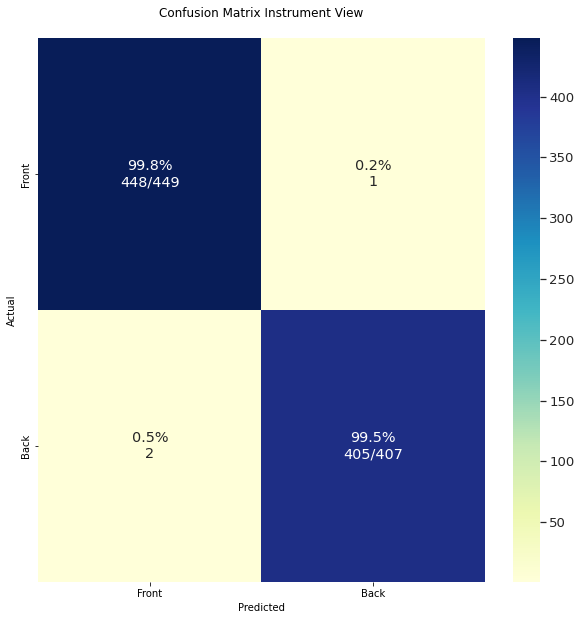

In [ ]:
with open("drive/MyDrive/CS342/alexnet_ins_view.dat", "rb") as f: # This is instrument type data
    alexnet_ins_view = pickle.load(f)
if "test_loader_ins_view" not in locals():
  with open("drive/MyDrive/CS342/test_loader_ins_view.dat", "rb") as f: # This is instrument type data
      test_loader_ins_view = pickle.load(f)
generate_pretty_confusion_matrix(alexnet_ins_view, test_loader_ins_view, ["Front", 'Back'], "drive/MyDrive/CS342/Confusion_Matrix_Ins_View",title="Confusion Matrix Instrument View\n")
del alexnet_ins_view
del test_loader_ins_view
# conf_matrix, class_report = generate_confusion_matrix_and_classification_report(alexnet_ins_view, test_loader_ins_view)

In [ ]:
with open("drive/MyDrive/CS342/alexnet_ins.dat", "rb") as f: # This is instrument type data
    alexnet_ins = pickle.load(f)
if "test_loader_ins" not in locals():
  with open("drive/MyDrive/CS342/test_loader_ins.dat", "rb") as f: # This is instrument type data
      test_loader_ins = pickle.load(f)
generate_pretty_confusion_matrix(alexnet_ins, test_loader_ins, ["Violin", 'Viola','Cello'], "drive/MyDrive/CS342/Confusion_Matrix_Ins_Type",title="Confusion Matrix Instrument Type\n")
del alexnet_ins
del test_loader_ins

In [ ]:
with open("drive/MyDrive/CS342/alexnet_country.dat", "rb") as f: # This is instrument type data
    alexnet_country = pickle.load(f)
if "test_loader_country" not in locals():
  with open("drive/MyDrive/CS342/test_loader_country.dat", "rb") as f: # This is instrument type data
      test_loader_country = pickle.load(f)
generate_pretty_confusion_matrix(alexnet_country, test_loader_country, ["Italy", 'France','Holland','USA', 'Germany','Austria',"Holland"], "drive/MyDrive/CS342/Confusion_Matrix_Ins_Country",title="Confusion Matrix Instrument Country Made\n")
del alexnet_country
del test_loader_country

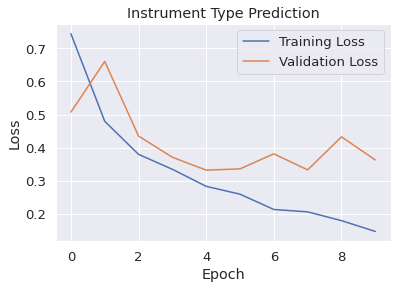

In [ ]:
with open("drive/MyDrive/CS342/ins_result_data.dat", "rb") as f: # This is instrument type data
      queue_loss_list_ins, train_loss_list_ins, val_loss_list_ins, test_acc_list_ins  = pickle.load(f)
plot_loss_train_eval({"Training Loss":train_loss_list_ins, "Validation Loss": val_loss_list_ins}, title = 'Instrument Type Prediction')

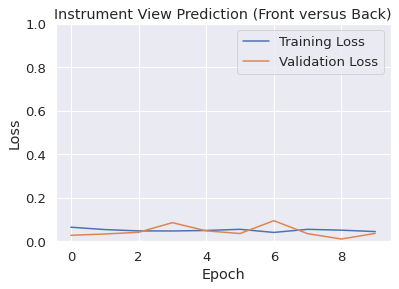

In [ ]:
with open("drive/MyDrive/CS342/alex_ins_view_results.dat", "rb") as f: # This is instrument type data
        queue_loss_list_ins_view, train_loss_list_ins_view, val_loss_list_ins_view, test_acc_list_ins_view = pickle.load(f)
loss_dict_ins_view = {"Training Loss":train_loss_list_ins_view, "Validation Loss": val_loss_list_ins_view}
plot_loss_train_eval(loss_dict_ins_view, title = 'Instrument View Prediction (Front versus Back)',y_axis_range =(0,1))

In [ ]:
with open("drive/MyDrive/CS342/alex_country_results.dat", "rb") as f:
  queue_loss_list_country, train_loss_list_country, val_loss_list_country, test_acc_list_country = pickle.load(f)
loss_dict_ins_view = {"Training Loss":train_loss_list_country, "Validation Loss": val_loss_list_country}
plot_loss_train_eval(loss_dict_ins_view,title = "Country Made Prediction" )

In [ ]:
with open("drive/MyDrive/CS342/alex_country_results.dat", "rb") as f:
  queue_loss_list_country, train_loss_list_country, val_loss_list_country, test_acc_list_country = pickle.load(f)
loss_dict_ins_view = {"Training Loss":train_loss_list_country, "Validation Loss": val_loss_list_country}
plot_loss_train_eval(loss_dict_ins_view,title = "Country Made Prediction" )

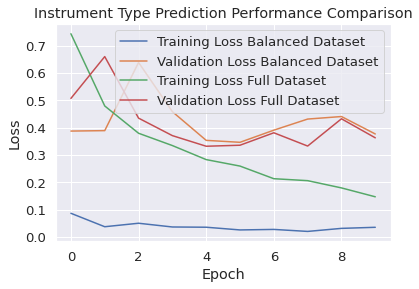

In [ ]:
with open("drive/MyDrive/CS342/ins_result_data.dat", "rb") as f:
  queue_loss_list_ins, train_loss_list_ins, val_loss_list_ins, test_acc_list_ins = pickle.load(f)
with open("drive/MyDrive/CS342/alexnet_ins_balanced_results.dat", "rb") as f:
  queue_loss_list_ins_balanced, train_loss_list_ins_balanced, val_loss_list_ins_balanced, test_acc_list_ins_balanced = pickle.load(f)
loss_dict_ins_comparision = {"Training Loss Balanced Dataset":train_loss_list_ins_balanced, "Validation Loss Balanced Dataset": val_loss_list_ins_balanced,"Training Loss Full Dataset":train_loss_list_ins, "Validation Loss Full Dataset": val_loss_list_ins}
plot_loss_train_eval(loss_dict_ins_comparision,title = "Instrument Type Prediction Performance Comparison" )

In [ ]:
plot_accuracy({"Instrument Type Prediction with Balanced Dataset": test_acc_list_ins_balanced, "Instrument Type Prediction with Weighted Loss":test_acc_list_ins}, title = "Accuracy Results from AlexNet")

In [ ]:
with open("drive/MyDrive/CS342/alex_country_results.dat", "rb") as f:
  queue_loss_list_country, train_loss_list_country, val_loss_list_country, test_acc_list_country = pickle.load(f)
with open("drive/MyDrive/CS342/alex_country_results_OPT2.dat", "rb") as f:
  queue_loss_list_country_OPT2, train_loss_list_country_OPT2, val_loss_list_country_OPT2, test_acc_list_country_OPT2 = pickle.load(f)
loss_dict_ins_view = {"Training Loss Local Standardization":train_loss_list_country_OPT2, "Validation Loss Local Standardization": val_loss_list_country_OPT2,"Training Loss Global Standardization":train_loss_list_country, "Validation Loss Global Standardization": val_loss_list_country}
plot_loss_train_eval(loss_dict_ins_view,title = "Country Made Prediction with Different Image Standardizations" )

In [ ]:
description_to_acc_list = {
    "Country Made Prediction with Global Standardization (Opt 1)" : test_acc_list_country ,
    "Country Made Prediction with Local Standardization (Opt 2)" : alexnet_country_OPT2
}
plot_accuracy(description_to_acc_list)

In [ ]:
description_to_acc_list = {
    "Instrument Type Prediction": test_acc_list_ins,
    'Instrument View Prediction (Front versus Back)': test_acc_list_ins_view,
    "Country Made Prediction" : test_acc_list_country
}
plot_accuracy(description_to_acc_list, title = "AlexNet Accuracy with Fine-Tuning \n and Modified Last Linear Layer")

### Computational Experiment: Off-the-Shelf versus Fine-Tuning
Compare the effectiveness of “off-the-shelf” to “fine-tuning” learning strategy.<br>
Question: 
Will fine-tuning all layers of AlexNet lead to increased performance compared to freezing the weights in earlier layers? Which method will lead to a better model for predicting instrument type and country made?<br>
Option 1: 
Only Modify the final Layer of AlexNet <br>
Option 2: 
Allow backpropagation and weight updating throughout all of AlexNet.<br>


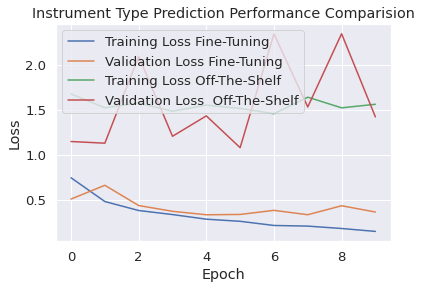

In [ ]:
# Computational Experiment 3:
with open("drive/MyDrive/CS342/ins_result_data.dat", "rb") as f: # This is instrument type data
        queue_loss_list_ins, train_loss_list_ins, val_loss_list_ins, test_acc_list_ins  = pickle.load(f)
# plot_loss_train_eval({"Training Loss":train_loss_list_ins, "Validation Loss": val_loss_list_ins}, title = 'Instrument Type Prediction')
with open("drive/MyDrive/CS342/ins_result_data_off_shelf.dat", "rb") as f: # This is instrument type data
        queue_loss_list_ins_off_shelf, train_loss_list_ins_off_shelf, val_loss_list_ins_off_shelf, test_acc_list_ins_off_shelf  = pickle.load(f)
plot_loss_train_eval({"Training Loss Fine-Tuning":train_loss_list_ins, "Validation Loss Fine-Tuning": val_loss_list_ins,
                      "Training Loss Off-The-Shelf":train_loss_list_ins_off_shelf, "Validation Loss  Off-The-Shelf": val_loss_list_ins_off_shelf}, title = 'Instrument Type Prediction Performance Comparision')

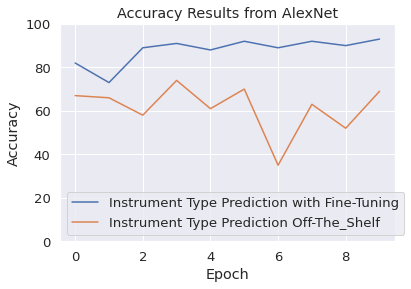

In [ ]:
plot_accuracy({"Instrument Type Prediction with Fine-Tuning": test_acc_list_ins, "Instrument Type Prediction Off-The_Shelf":test_acc_list_ins_off_shelf}, title = "Accuracy Results from AlexNet")

### Computational Experiment: Creating Class Saliency Map to Detect Important Features <br>
Question:
What parts of a musical instrument are most important for predicting the view and type of instrument?<br>

Methodology:
We decide which part of the image is most important by adding peturbations to an image, and then we attribute the activation of unit i to specific elements of each input. We compute difference in activations by the following formula: Δai(X’) = |ai(X) — ai(X’)|. Below is an example of a large perturbation to an input image that decreases the performance of the model. For the results below, our buble size is 15 pixels in diameter.


In [ ]:
# function that adds bubbles to an image ( a circle of zeroes that replaces existing pixel values at a x,y location)
def peturb_image(input_image, x_center, y_center, bubble_size):
    input_image_copy = copy.deepcopy(input_image)
#     print(input_image_copy)
    xx, yy,zz = np.meshgrid(range(224), range(224), range(3))
    image_mask = (np.sqrt((xx - y_center)**2 + (yy - x_center)**2) > bubble_size//2).astype(np.float32)
#     print(image_mask)
    image_mask_tensor = torch.tensor(image_mask, dtype=torch.float32).cpu()
#     print(image_mask_tensor.shape)
    image_with_mask= image_mask_tensor * torch.transpose(input_image_copy,0, 2).cpu()
    image_with_mask = torch.transpose(image_with_mask,0, 2)
    # Makes values white instead of 0
    image_with_mask[image_with_mask==0] = torch.max(image_with_mask)
#     image_with_mask = image_with_mask[image_with_mask==0] = 2
#     for i in range()
    return image_with_mask

def reverse_dimensions(arr):
    arr1 =  torch.transpose(arr, 0 , 2)
    arr2 = torch.transpose(arr1, 0 , 1)
    return arr2

In [ ]:
# Calculates and returns difference in loss of bubble peturbations at each pixel
def calc_attribution_bubbles(image_arr, model, criterion, step_size = 4, bubble_size=10):
    loss_difference_vals = torch.zeros(256,256)
    output_ins_type = image_arr[1]
    orig_image = peturb_image(copy.deepcopy(image_arr[0]), x_center = 0, y_center=0, bubble_size=0)
    orig_predicted = model.forward(orig_image.unsqueeze(0).to(device))
    pred = torch.tensor(output_ins_type).unsqueeze(0).to(device)
    assert pred.is_cuda and orig_predicted.is_cuda
    orig_loss = criterion(orig_predicted, pred)
    for i_pixel in range(0,256,step_size):
        for j_pixel  in range(0,256,step_size):
            modified_input_image = peturb_image(copy.deepcopy(image_arr[0]), i_pixel, j_pixel, bubble_size)
            with torch.no_grad():
                input_squeezed = modified_input_image.unsqueeze(0).to(device)
                assert input_squeezed.is_cuda
                predicted = model.forward(input_squeezed)
    #             predicted = alexnet_ins.forward(torch.zeros(3,256,256).unsqueeze(0))
#                 print("predicted: {}".format(predicted))
                ans = torch.tensor(output_ins_type).unsqueeze(0).to(device)
                assert ans.is_cuda
                loss = criterion(predicted, ans) 
                # print("loss: {}".format(loss))
                loss_difference_vals[i_pixel][j_pixel] = loss - orig_loss
    return loss_difference_vals

In [ ]:
def showTensor(tensor):
    plt.figure()
    plt.imshow(tensor.numpy())
    plt.colorbar()
    plt.show()

In [ ]:
if LOAD_INS_VIEW or LOAD_INS_TYPE:
  if "class_weights_ins" not in locals():
    with open("drive/MyDrive/CS342/class_weights_ins.dat", "rb") as f:
        class_weights_ins = pickle.load(f)
  if "criterion_ins_extra_layer" not in locals():
    criterion_ins_extra_layer = nn.CrossEntropyLoss(weight=class_weights_ins,reduction='mean')


In [ ]:
image_ins_type_only[20]

with open("drive/MyDrive/CS342/image_ins_type_only[2].dat", "wb") as f:
    pickle.dump(image_ins_type_only[2], f)


with open("drive/MyDrive/CS342/image_ins_type_only[8230].dat", "wb") as f:
    pickle.dump(image_ins_type_only[8230], f)

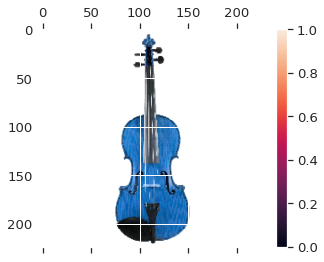

In [ ]:
show_image_processed(image_ins_type_only[8230][0]) # 8230 Violin

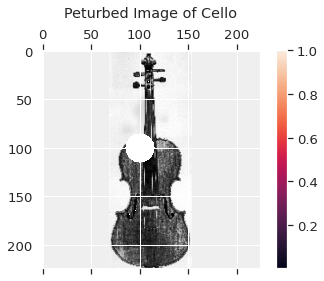

In [ ]:
peturbed_image = peturb_image(image_ins_type_only[2][0], x_center = 100, y_center=100, bubble_size=30)
show_image_processed(peturbed_image,save_name= "Peturbed Image Cello",title="Peturbed Image of Cello\n")

In [ ]:
attribution_bubbles_cello = calc_attribution_bubbles(image_ins_type_only[20], alexnet_ins, criterion_ins_extra_layer,step_size=1)

In [ ]:
attribution_bubbles_violin = calc_attribution_bubbles(image_ins_type_only[8230], alexnet_ins, criterion_ins_extra_layer,step_size=1)

In [ ]:
# Dumb function that creates new array of reshaped tensor images. Similar to torch.transpose 
def convert_image_to_show(attribution_bubles):
  image_with_peturbation=torch.zeros(([3,256,256]))
  for i in range(image_with_peturbation.shape[0]):
      for j in range(image_with_peturbation.shape[1]):
          for k in range(image_with_peturbation.shape[2]):
              image_with_peturbation[i][j][k] = attribution_bubles[k][j]
  return image_with_peturbation

In [ ]:
attribution_bubbles_cello_converted = convert_image_to_show(attribution_bubbles_cello)

In [ ]:
attribution_bubbles_cello_converted = convert_image_to_show(attribution_bubbles_cello)
show_image_processed(attribution_bubbles_cello_converted)
with open("peturbation_map_ins_cello.dat", "wb") as f:
    pickle.dump(attribution_bubbles_cello_converted, f)

In [ ]:
show_image_processed(attribution_bubbles_violin)
with open("peturbation_map_ins_violin.dat", "wb") as f:
    pickle.dump(attribution_bubbles_violin, f)

In [ ]:
show_image_processed(image_with_peturbation)

In [ ]:
show_image_processed(attribution_bubbles_cello_converted,save_name= "cello_saliency",title="Saliency Map of Cello for Predicting Instrument Type\n")

In [ ]:
show_image_processed(images[2],save_name= "violin_saliency_map", title="Saliency Map of Violin for Predicting Instrument View\n",)

Note to grader: The following is extra work that is not a computational experiment, but that I still wanted to include so that I could improve when I pickup this project once again

In [ ]:
# Future Optimizations: Modify loss function to make optimized image not random looking. ex: https://distill.pub/2017/feature-visualization/
import random 
class InputOptim(nn.Module):
    def __init__(self, model, optimized_input = None):
        
        super().__init__()
        self.model = model
        if optimized_input == None:
            self.optimized_input = torch.zeros((1,3,256,256)).requires_grad_(True)
        else:
            self.optimized_input = optimized_input
        
    def forward(self, x):
        pred = self.model.forward(x)
        return pred
    
    def parameters(self):
        return [self.optimized_input]

'''
Notes on potential Future Optimization:
  clipping cvalues(make sure they don't exceed fix range)
  need regularization: weight decay, or explicit penalty to loss (add some factor times the sum of the squares of some pixel values)
  apply more interesting penalties to make it more image like, penalize it if it creates images that are Graph
  total variation norm/ total variation denoising (sometimes called tv1 norm(make image prefer flat patches/[pieceswise]): forces image to only tv2 norm(prefers smooth norm))
  blur image early on (slowly decrease blurring ) or blur after each step maybe

'''

"\nNotes on potential Future Optimization:\n  clipping cvalues(make sure they don't exceed fix range)\n  need regularization: weight decay, or explicit penalty to loss (add some factor times the sum of the squares of some pixel values)\n  apply more interesting penalties to make it more image like, penalize it if it creates images that are Graph\n  total variation norm/ total variation denoising (sometimes called tv1 norm(make image prefer flat patches/[pieceswise]): forces image to only tv2 norm(prefers smooth norm))\n  blur image early on (slowly decrease blurring ) or blur after each step maybe\n\n"

In [ ]:
# Dumb code that returns index of instrument that does not perform well with alexNet
def get_terrible_prediction_ins_view():
    for index in range(5,10000):
        image = image_to_back_or_front_category_np[index][0].unsqueeze(dim=0)
        pred = alexnet_ins_view(image)
        actual = torch.tensor(image_to_back_or_front_category_np[index][1]).unsqueeze(dim=0)
        # actual = torch.tensor(image_to_back_or_front_category_np[index][0])
    #     print(actual.shape)
        loss = criterion_ins_view(pred, actual)
        if loss>2.5:
            print(index)
            print(loss)
            return index
index_bad_ins =get_terrible_prediction_ins_view()
index_bad_ins

In [ ]:

def optimize_photo(ins_index, model, n_epochs=20, lr=22):
    # input_model = InputOptim(alexnet_ins_view, optimized_input = None)
    input_model = InputOptim(alexnet_ins_view, optimized_input = image_to_back_or_front_category_np[ins_index][0].clone().unsqueeze(dim=0).requires_grad_(True))
    optimizer = torch.optim.Adam(input_model.parameters(), lr=lr)
    lossfxn  = nn.CrossEntropyLoss() 
    t = image_to_back_or_front_category_np[ins_index][1]
    # image_to_back_or_front_category_np[2][0]
    # image_to_back_or_front_category_np[2][1]
    print("target: ", t)
    for itr, epoch in enumerate(range(n_epochs)):
        optimizer.zero_grad()
        pred = input_model.forward(input_model.optimized_input)
        target = torch.tensor([t], dtype=torch.int64)
        loss = lossfxn(pred, target) 
        if not itr%10:
            print("loss %f" % loss)
        loss.backward()
        optimizer.step()  
    return input_model.optimized_input.squeeze().detach()
    
optimized_photo_1 = optimize_photo(557, alexnet_ins_view, n_epochs=30, lr=.02)
optimized_photo_2 = optimize_photo(557, alexnet_ins_view, n_epochs=30, lr=.2)
optimized_photo_3 = optimize_photo(557, alexnet_ins_view, n_epochs=30, lr=2)

In [ ]:
show_image_processed(image_to_back_or_front_category_np[557][0])

In [ ]:
show_image_processed(optimized_photo_1)

In [ ]:
show_image_processed(optimized_photo_2)

In [ ]:
show_image_processed(optimized_photo_3)